We consider the program `suma.c`.

```C
//
// helloflops1
//
// A simple example to try 
// to get lots of Flops 
//

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

//
// Main program - 
// 
void main(int argc, char *argv[] ) 
{
  // Problem size parameters
  const int MAXFLOPS_ITERS = (argc > 1 ? atoi(argv[1]) : 10000000);
  const int LOOP_COUNT = (argc > 2 ? atoi(argv[2]) : 64);
        int i,j,k;
        float suma = 0.0;

        printf("Starting Compute\r\n");

        // loop many times to really get lots of calculations
        for(j=0; j<MAXFLOPS_ITERS; j++)  
        {
        //
        // just to sum a variable a lot of times 
        //
            for(k=0; k<LOOP_COUNT; k++)  
   	    {
               	suma+=1.0;
            }
	 }

         //
         // Print the results
         //
         printf("suma = %10.3lf\r\n", suma);
}
```

The following code creates a wrapper for the C main called `c_main`.

In [1]:
using Libdl
C_code = """
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

float suma(int argc, char *argv[]) 
{
    const int MAXFLOPS_ITERS = (argc > 1 ? atoi(argv[1]) : 10000000);
    const int LOOP_COUNT = (argc > 2 ? atoi(argv[2]) : 64);
    int i,j,k;
    float suma = 0.0;
    for(j=0; j<MAXFLOPS_ITERS; j++)  
    {
        for(k=0; k<LOOP_COUNT; k++)  
        {
            suma+=1.0;
        }
    }
    return suma;
}

"""

const Clib = tempname()   # make a temporary file

# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_main(x::Int, y::Int) = ccall(("suma", Clib), Cfloat, (Cint, Ptr{Cstring}), 3, ["a.out", "$(x)", "$(y)"])

c_main (generic function with 1 method)

Example usage:

In [2]:
c_main(2, 8)

16.0f0

We want to answer the question:

Why does the code always output $min(xy, 2^{24})$ instead of $xy$ where $x$ and $y$ are the two parameters?

In [3]:
println(Int(c_main(100, 200)))
println(Int(c_main(1000, 1000)))
println(Int(c_main(100000, 1000)))

20000
1000000
16777216


The reason has to do with how floating point numbers are stored. C's floats follow the IEEE754 standard. The 32-bit floating point numbers use $1$ bit for sign, $23$ for significand and $8$ for exponent. This means that the precision is not infinite and that there exist numbers to which, if we add $1$, remain the same number because it doesn't alter the relevant digits of the significand.

Because a 32-bit float can store $24$ digits for the significand ($1$ is implicit), all numbers smaller than $2^{24}$ can be represented an obtained by adding $1$. IEEE754 mandates that the add operation between floating point numbers behaves as if it were an infinite precision operation and that the result is rounded to the nearest even representable integer. $2^{24}$ can be stored because it only needs $1$ bit of significand. However, $2^{24}+1$ needs (and is the first number to do so) $25$ bits of significand and it is odd. Therefore, the operation $2^{24}+1$ yields $2^{24}$.

The second question we want to answer is what are the GFLOPS for this code of our machine.

First, we are going to test the function's time with `@elapsed`. Because the original code is a pair of loops, it should be better to plot the values as a 3d function. However, because the two for loops together act as a single loop of size the product of their iterations, we are going to leave the value of the outer loop in 1 and vary the other one.

Note: a better approach would be to do more than one measure per number of iterations. We will keep it simple now.

In [4]:
ranges = 0:500:1000000
times = [@elapsed c_main(1,j) for j = ranges]

2001-element Array{Float64,1}:
 1.5828e-5
 1.613e-6
 2.465e-6
 3.406e-6
 4.411e-6
 5.487e-6
 6.563e-6
 7.563e-6
 8.551e-6
 1.883e-5
 1.0432e-5
 1.143e-5
 1.2507e-5
 ⋮
 0.002035636
 0.002076854
 0.002064545
 0.002097958
 0.00209133
 0.002061357
 0.002042799
 0.002044573
 0.00204389
 0.002087835
 0.00225157
 0.002155214

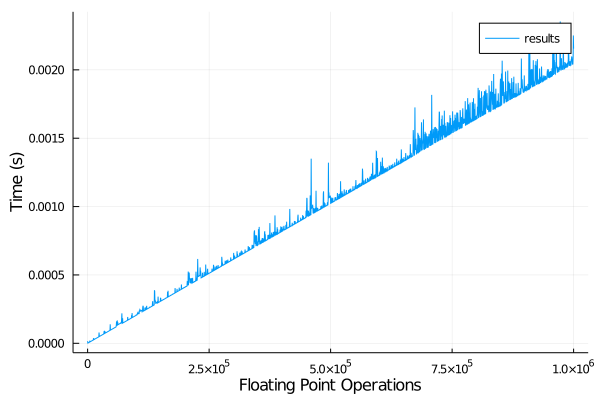

In [5]:
using Plots
plot(ranges, times, label="results")
xlabel!("Floating Point Operations")
ylabel!("Time (s)")

The resulting function is almost a straight line. We can see some spikes, always above the line, in execution time. Because they don't happen below the line, we can think of the imaginary line as a lower bound on the time it takes to execute the code in this machine given the input. The spikes can correspond to moments were the code was interrupted or the processor was busy.

We will now find the slope of the line to determine the GFLOPS of the current machine.

In [6]:
# Finding the lower bound for the linear regression coeficient
λ = minimum(times./ranges)

2.0468455804046857e-9

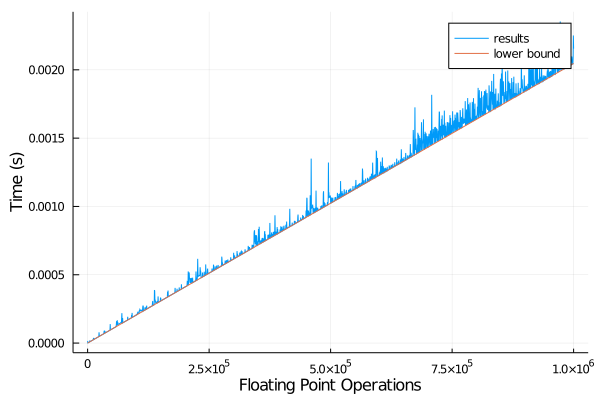

In [7]:
regression = ranges*λ
plot!(ranges, ranges*λ, label="lower bound")

We got an upper bound of $λ ≈ 2.046851e-9$ FLOPS for our machine.

That is, $2.0468$ GFLOPS.

Let's see for what percentage of the times the calculated the bound is tight (it seemed that for a lot at first). We'll count how many times are at most $1$% slower than the time given by the bound.

In [8]:
bound_tightness = count(<=(1.01), times./regression)/length(ranges)

0.6031984007996002

More than $50$%.

We can conclude that it is a good bound.